# Global Climate Analysis
By Jie Li， Zehao Li, and Jingkai Zheng  <br>
Dec 15, 2022

# **Motivation**
Considering the increasing frequency of abnormal weather patterns in the past years—hurricanes, wildfires, floods, heatwaves, etc., we believe that a thorough and detailed analysis on world's temperature data would illustrate the severity of the issue at hand and serve great value to the public.

In this project, we take comprehensive climate trends data from Berkeley Earch, which contains temperature reports across the globe from 1750 to 2015, and develop various predictive machine learning models to forecast future temperatures.

# 0 Imports and Loading Datasets

In [237]:
# data processing
import pandas as pd
import numpy as np

# garbage collection
import gc

# pretty progres bar
from tqdm import tqdm

# patriotic library; convert state names to abbreviations
import us

# regex for string manipulation
import re

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import * # ggplot2 for python
import plotly.express as px # interactive plots with plotly
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # autocorrelation plots

# generate word clouds
from wordcloud import WordCloud
from collections import Counter

# mute Python
import warnings
warnings.filterwarnings("ignore")

# preprocessing
from sklearn.preprocessing import KBinsDiscretizer # ordinal encoding
from keras.utils.np_utils import to_categorical  # one-hot encoding

# sklearn models
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

# catboost
from catboost import CatBoostRegressor

# pytorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42) # fix seed for reproducibility

PATH = {
    "global": "GlobalTemperatures.csv",
    "country": "GlobalLandTemperaturesByCountry.csv",
    "state": "GlobalLandTemperaturesByState.csv",
    "major_city": "GlobalLandTemperaturesByMajorCity.csv",
    "city": "GlobalLandTemperaturesByCity.csv",
}

In [238]:
DF_global = pd.read_csv(PATH["global"])
DF_country = pd.read_csv(PATH["country"])
DF_state = pd.read_csv(PATH["state"])
DF_major_city = pd.read_csv(PATH["major_city"])
DF_city = pd.read_csv(PATH["city"])

# DF stores 5 dataset in a list, convenient for later column cleaning
DF = [DF_global, DF_country, DF_state, DF_major_city, DF_city]

# 1 Exploratory Data Analysis (EDA)

## 1.1 Overview

### 1.1.1 Global Temperatures

The first dataset we are analyzing consists of land and ocean temperatures dated back to 1750. It records how land average temperature, maximum and minimum land temperature, and land and ocean average temperature have changed over time. The dataset would be mainly used for visualizing drastic change in global climate over past two centuries and training machine learning model for predicting future temperatures.

In [239]:
print(DF_global.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB
None


Note that uncertainty columns for land average, max, min temperature denote the 95% confidence interval around the average, which adds on accuracy to records/approximation of temperature long time ago.

In [240]:
print(DF_global.iloc[0])

dt                                           1750-01-01
LandAverageTemperature                            3.034
LandAverageTemperatureUncertainty                 3.574
LandMaxTemperature                                  NaN
LandMaxTemperatureUncertainty                       NaN
LandMinTemperature                                  NaN
LandMinTemperatureUncertainty                       NaN
LandAndOceanAverageTemperature                      NaN
LandAndOceanAverageTemperatureUncertainty           NaN
Name: 0, dtype: object


In [241]:
print(f"Earlist Entry: {DF_global['dt'].min()}")
print(f"Most Recent Entry: {DF_global['dt'].max()}")

Earlist Entry: 1750-01-01
Most Recent Entry: 2015-12-01


### 1.1.2 Global Temperatures by Country

This dataset documents the change of average temperatures in 243 countries and regions (in 2013) from 1740s to 2010s, which would be used for illustrating climate trends by country across time and analyzing trends in regions with different geographical locations.  

In [242]:
print(DF_country.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB
None


In [243]:
print(DF_country.iloc[-1])

dt                               2013-09-01
AverageTemperature                      NaN
AverageTemperatureUncertainty           NaN
Country                            Zimbabwe
Name: 577461, dtype: object


In [244]:
print(f"Earlist Entry: {DF_country['dt'].min()}")
print(f"Most Recent Entry: {DF_country['dt'].max()}")
print(f"Numbers of Countries: {DF_country['Country'].nunique()}")

Earlist Entry: 1743-11-01
Most Recent Entry: 2013-09-01
Numbers of Countries: 243


### 1.1.3 Global Temperatures by State

This is the second largest dataset in the bundle, which composes of temperature change in major states among majority of countries from 1850s to 2010s. Comparing to state dataset, it provides more precise data point in one particular state, which allows for more accurate analysis and prediction for temperature trends. Specifically, we would extract temperature records of US states, visualize them, and analyze them thoroughly.

In [245]:
print(DF_state.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB
None


In [246]:
print(DF_state.iloc[0])

dt                               1855-05-01
AverageTemperature                   25.544
AverageTemperatureUncertainty         1.171
State                                  Acre
Country                              Brazil
Name: 0, dtype: object


In [247]:
print(f"Earlist Entry: {DF_state['dt'].min()}")
print(f"Most Recent Entry: {DF_state['dt'].max()}")
print(f"Countries: {', '.join(sorted(DF_state['Country'].unique()))}")
print(f"Number of States: {DF_state['State'].nunique()}")

Earlist Entry: 1743-11-01
Most Recent Entry: 2013-09-01
Countries: Australia, Brazil, Canada, China, India, Russia, United States
Number of States: 241


### 1.1.4 Global Temperatures by Major City

This dataset further reduces in scope for temperature data points. It not only records the average temperature changes in major cities across the global from 1840s to 2010s and also includes latitude and longtitude information for each city. 

In [248]:
print(DF_major_city.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB
None


In [249]:
print(DF_major_city.iloc[-1])

dt                               2013-09-01
AverageTemperature                      NaN
AverageTemperatureUncertainty           NaN
City                                   Xian
Country                               China
Latitude                             34.56N
Longitude                           108.97E
Name: 239176, dtype: object


In [250]:
print(f"Earlist Entry: {DF_major_city['dt'].min()}")
print(f"Most Recent Entry: {DF_major_city['dt'].max()}")
print(f"Numbers of Countries: {DF_major_city['Country'].nunique()}")
print(f"Number of Major Cities: {DF_major_city['City'].nunique()}")

Earlist Entry: 1743-11-01
Most Recent Entry: 2013-09-01
Numbers of Countries: 49
Number of Major Cities: 100


### 1.1.5 Global Temperatures by City

The city dataset is the largest dataset with 8m+ entries of average temperatures among majority of cities in the world, which would used for training out ML model for future temperatures.

In [251]:
print(DF_city.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB
None


In [252]:
print(DF_city.iloc[0])

dt                               1743-11-01
AverageTemperature                    6.068
AverageTemperatureUncertainty         1.737
City                                  Århus
Country                             Denmark
Latitude                             57.05N
Longitude                            10.33E
Name: 0, dtype: object


In [253]:
print(f"Earlist Entry: {DF_city['dt'].min()}")
print(f"Most Recent Entry: {DF_city['dt'].max()}")
print(f"Numbers of Countries: {DF_city['Country'].nunique()}")
print(f"Number of Cities: {DF_city['City'].nunique()}")
print(f"Number of Non-Major Cities: {len(set(DF_city['City'].unique()) - set(DF_major_city['City'].unique()))}")

Earlist Entry: 1743-11-01
Most Recent Entry: 2013-09-01
Numbers of Countries: 159
Number of Cities: 3448
Number of Non-Major Cities: 3348


Note that null value appears quite frequenctly amonmg those five datasets, and however, it would not be a huge obstacle in analysis and modeling. Some of our workarounds include only paying attention to time period where the datapoints are ample and conduting interpolation.

## 1.2 Column Cleaning

In this section, we want to do basic column cleaning for future convenience. It includes unifying column names in all datasets, extracting year and month columns, and converting date object to date-time type. To further increase convenience, we also convert longtitude and latitude values from string type to numeric, with positive longtitude value representing East, negative longtitude value representing West, positive latitude value representing North, and negative latitude representing South.

### 1.2.1 Convert Column Names to Snake Case

In [254]:
# change ColName to col_name
def to_snake_case(name):
    return re.sub(r"([A-Z])", r"_\1", name).lower().strip("_")

for df in DF:
    df.columns = df.columns.map(to_snake_case)

### 1.2.2 Add `year`, `month` Columns

In [255]:
# extract year and month
for df in DF:
    df[["year", "month", "day"]] = df["dt"].str.split("-", expand=True).astype(int)
    df.drop(["day"], axis = 1, inplace = True)

### 1.2.3 Convert `dt` to `datetime`

In [256]:
# convert to datetime type
for df in DF:
    df.dt = pd.to_datetime(df.dt)

### 1.2.4 Convert `latitude` and `longitude` to Numeric in `DF_major_city` and `DF_city`

In [257]:
# north hemisphere -> positive; south hemisphere -> negative
# east hemisphere -> positive; west hemisphere -> negative
convert_lat = lambda x : x.replace('N','') if 'N' in x else '-' + x.replace('S','')
convert_long = lambda x : x.replace('E','') if 'E' in x else '-' + x.replace('W','')

for df in [DF_major_city, DF_city]:
    df.latitude = df.latitude.map(convert_lat).astype(float)
    df.longitude = df.longitude.map(convert_long).astype(float)

## 1.3 Globe

In this section, we want to explore the average temperature change across the globe from 1850 to 2015. We use color to denote the mean temperature each year for each country. Red suggests a country's mean temperature is high and above zero, while blue means that the temperature is cold and below zero. 

### 1.3.1. Temperature over Time

In the graph below, we use an animation to show how the average annual temperature has changed from 1850 to 2012. We can see that countries near the equator generally have high average temperature regardless of the year, while countries near the North pole have low average temperature. From the animation, it is hard to determine whether the average temperature of countries have changed over time. However, if we compare the color of countries between year 1850 and 2012, we can see that there are some very subtle changes. For example, the color of the US change from light orange to a darker orange, and the color of Greenland changes from dark blue to ligher blue. 

In [258]:
fig = px.choropleth((DF_country.copy(deep = True)
                               .dropna()
                               .query('year >= 1850')
                               .loc[:, ['country', 'year', 'month', 'average_temperature']]
                               .groupby(['year', 'country'])
                               .filter(lambda x: len(x) == 12)
                               .groupby(['year', 'country'])
                               .agg({'average_temperature': 'mean'})
                               .reset_index()), 
                    locations="country",
                    animation_frame = "year", #  
                    locationmode='country names',
                    color="average_temperature",
                    range_color = [-20, 30],
                    hover_name="country",
                    color_continuous_scale = 'RdBu_r',
                    title = 'Average Temperature by Country (1850-2013)',
                    height = 800,
                    width = 1000)
                    

fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 1

fig.show()

### 1.3.2. Absolute Temperature Change by Country

In the graph below, we use a 3D plot of the globe to show the absolute change of average temperature for all countries between the first decade of 20th century and the most recent decade. The redder the graph, the more temperature has increased in the last hundred years. Interestingly, we see that the countries closer to the North Pole experienced higher temperature increase than countires near the equator. For example, the average temperature of Canada increases around 2 Celsius in the last hundred years, while that of Mexico increases around 0.95 Celsius. It is unclear why global temperature changes in an unbalanced manner. Our hypothesis is that the Ozone layer around the North and South Pole has been damaged because of some chemicals released by human beings, and the Ozone hole allows strong solar radiation to penetrate the atmosphere without any filtering, which may lead to more rapid heating of the area in the North and South Pole. 

In [259]:
temp_df = (DF_country.copy(deep = True)
                     .dropna()
                     .query('year >= 1900')
                     .loc[:, ['country', 'year', 'month', 'average_temperature']]
                     .groupby(['year', 'country'])
                     .filter(lambda x: len(x) == 12)
                     .groupby(['year', 'country'])
                     .agg({'average_temperature': 'mean'})
                     .reset_index())

past_df = (temp_df.query('year >= 1900 and year <= 1909')
                  .groupby('country')
                  .agg({'average_temperature': 'mean'}))
present_df = (temp_df.query('year >= 2006 and year <= 2015')
                     .groupby('country')         
                     .agg({'average_temperature': 'mean'}))

temp_df = past_df.merge(present_df, on = 'country', suffixes = ('_past', '_present')).reset_index()

temp_df['change_of_average_temperature'] = temp_df['average_temperature_present'] - temp_df['average_temperature_past']

In [260]:
fig = px.choropleth(temp_df,
                    locations="country",
                    locationmode='country names',
                    color="change_of_average_temperature",
                    range_color = [0, 3],
                    hover_name="country",
                    projection="orthographic",
                    color_continuous_scale = 'reds',
                    title = 'Absolute Temperature Change by Country (1900-1909 vs. 2006-2015))',
                    height = 800,
                    width = 1000) 

fig.show()

### 1.3.3 Absolute Temperature Change by Country (Word Cloud)

In the WordCloud, we display countries with larger change of average temperature over the last hundred of years with larger texts. For example, we can clearly see that Svalbard And Jan Mayen has the largest temperature increase. 

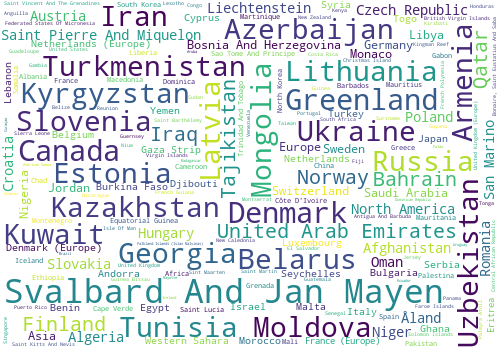

In [261]:
cnt = Counter({k:int(v*1000) for k, v in zip(temp_df["country"], temp_df["change_of_average_temperature"])})

wordcloud = WordCloud(background_color = 'white',
                       width = 500,
                       height = 350
                      ).generate_from_frequencies(cnt).to_image()
wordcloud

## 1.4 Analysis on G20 Countries

In this section, we hope to focus on a smaller set of countries, aiming to gain a more micro perspective regarding how temperature has changed over time. Since the G20 Bali Summit just ended, we decide to investigate how these countries' annual temperature has changed over time, as these countries' actions in combating global warming contain more significance and power. G20 contains 19 countries and European Union, and we exclude European Union to make the sample unit consistent. 

In [262]:
df_global = (DF_global.copy(deep = True)
                      .rename(columns = {'land_and_ocean_average_temperature': 'average_temperature'})
                      .dropna()
                      .query("year >= 1850")
                      .assign(country = 'World')
                      .loc[:, ['country', 'year', 'month', 'average_temperature']]
)

G20 = ['Australia', 'Argentina',
       'Brazil', 
       'Canada', 'China', 
       'France', 'Germany', 
       'India', 'Indonesia', 'Italy', 
       'Japan', 'Mexico', 'Russia', 
       'Saudi Arabia', 'South Africa', 'South Korea', 
       'Turkey', 
       'United Kingdom', 'United States'] # Minus EU

df_g20 = (DF_country.copy(deep = True)
                    .dropna()
                    .query('(country in @G20) & (year >= 1850)')
                    .loc[:, ['country', 'year', 'month', 'average_temperature']]
)

# Concatenate df_g20 and df_global
df = pd.concat([df_g20, df_global], ignore_index = True)

### 1.4.1 How have annual temperatures changed over time?

In the graph below, we investigate how the mean annual temperatures of G20 countries have changed from 1850 to 2015. By looking at the trend lines, we can easily tell that all countries' annual temperatures have been rising in the last one and a half centuries. By examing the color which denotes temperature, we can see that annual temperature has increased in different climate regions. By viewing the graph for the world as a whole, we further confirm that global warming is actually a global phenomenon. The mean annual temperature in the world has increased from around 15 Celsius to 16 Celsius in the last one and a half centuries.

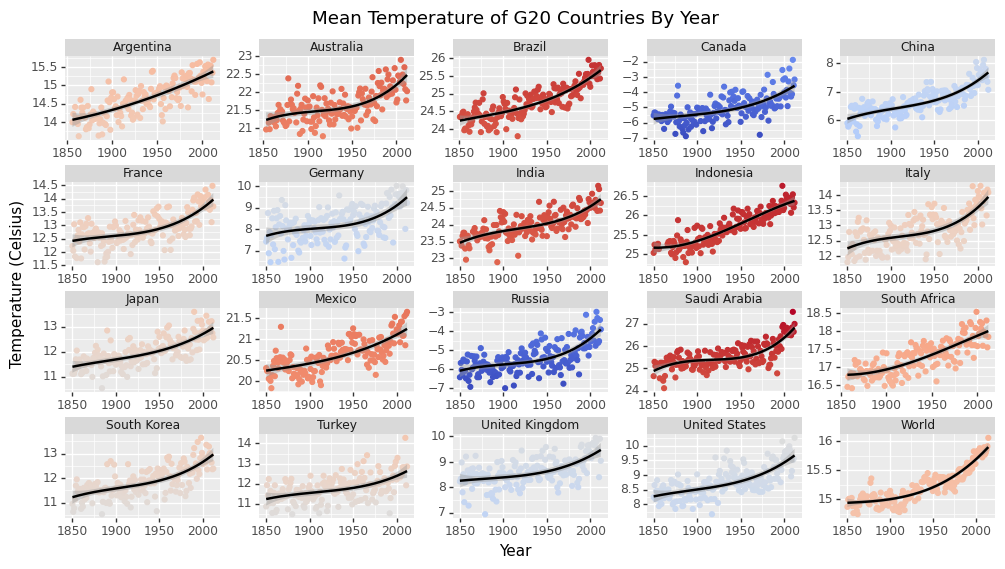

<ggplot: (175119171012)>

In [263]:
(ggplot((df.groupby(['year', 'country'])
           .filter(lambda x: len(x) == 12)
           .groupby(['year', 'country'])
           .agg({'average_temperature': 'mean'})
           .reset_index()
))  + aes(x='year', y='average_temperature', color='average_temperature')
    + geom_point()
    + geom_smooth(method = 'lm', formula = 'y ~ x + I(x**2) + I(x**3) + I(x**4)', se = True)
    + facet_wrap('~country', scales = "free")
    + scale_color_cmap('coolwarm')
    + labs(title='Mean Temperature of G20 Countries By Year', x='Year', y='Temperature (Celsius)')
    + theme(figure_size=(12, 6), subplots_adjust={'wspace': 0.25, 'hspace': 0.5}, legend_position='none')
)

### 1.4.2 How have max temperatures changed over time?

In the graph below, we investigate how the maximum temperatures of G20 countries in a single year have changed from 1850 to 2015. By looking at the trend lines, we can tell that all countries' maximum temperatures have been rising in the last one and a half centuries. By examing the color which denotes temperature, we can see that maximum temperature has increased in different climate regions. By viewing the graph for the world as a whole, we further confirm that global warming is happening all around the world. Interestingly, the maximum temperature has been steady or even declining between 1850 and 1900 for countries like France, Indonesia, Mexico, United Kingdom, and United States. Moreover, for most G20 countries, the maximum temperature has been rising on a much faster pace after 1950. One notable example is Saudi Arabia, Russia, Turkey. 

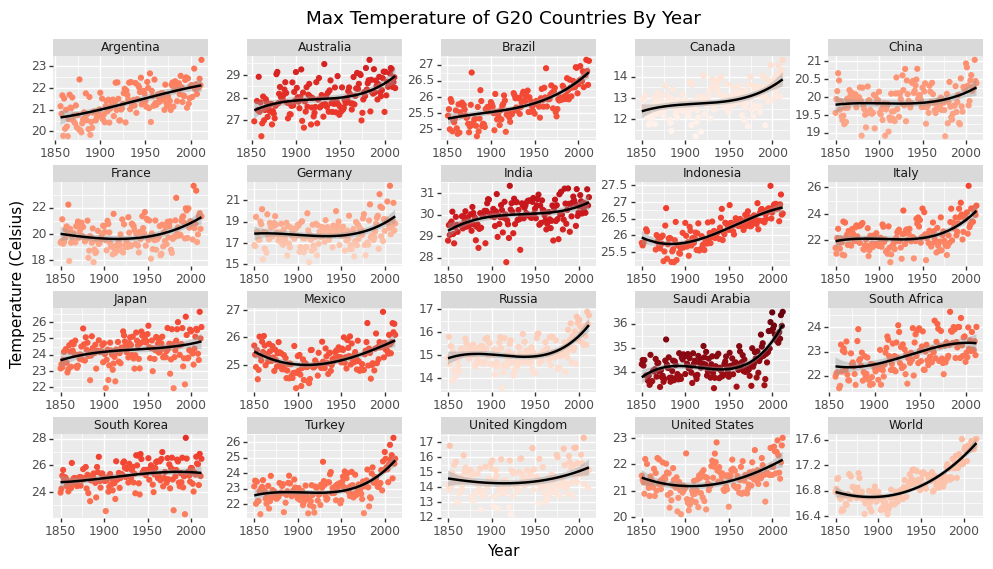

<ggplot: (175022434067)>

In [264]:
(ggplot((df.groupby(['year', 'country'])
           .filter(lambda x: len(x) == 12)
           .groupby(['year', 'country'])
           .agg({'average_temperature': 'max'})
           .reset_index()
))  + aes(x='year', y='average_temperature', color='average_temperature')
    + geom_point()
    + geom_smooth(method = 'lm', formula = 'y ~ x + I(x**2) + I(x**3) + I(x**4)', se = True)
    + facet_wrap('~country', scales = "free")
    + scale_color_cmap('Reds')
    + labs(title='Max Temperature of G20 Countries By Year', x='Year', y='Temperature (Celsius)')
    + theme(figure_size=(12, 6), subplots_adjust={'wspace': 0.25, 'hspace': 0.5}, legend_position='none')
)

### 1.4.3 How have min temperatures changed over time?

In the graph below, we investigate how the minimum temperatures of G20 countries in a single year have changed from 1850 to 2015. By looking at the trend lines, we can tell that all countries' minimum temperatures have been rising in the last one and a half centuries. By examing the color which denotes temperature, we can see that minimum temperature has increased in different climate regions. By viewing the graph for the world as a whole, we further confirm that global warming is happening all around the world. Interestingly, the minimum temperature has been steady or even declining between 1850 and 1900 for countries like Argentina, Australia, Brazil, and Canada. Moreover, for most G20 countries, the minimum temperature has been rising on a much faster pace after 1950. One notable example is Japan, Germany, and United Kingdom. 

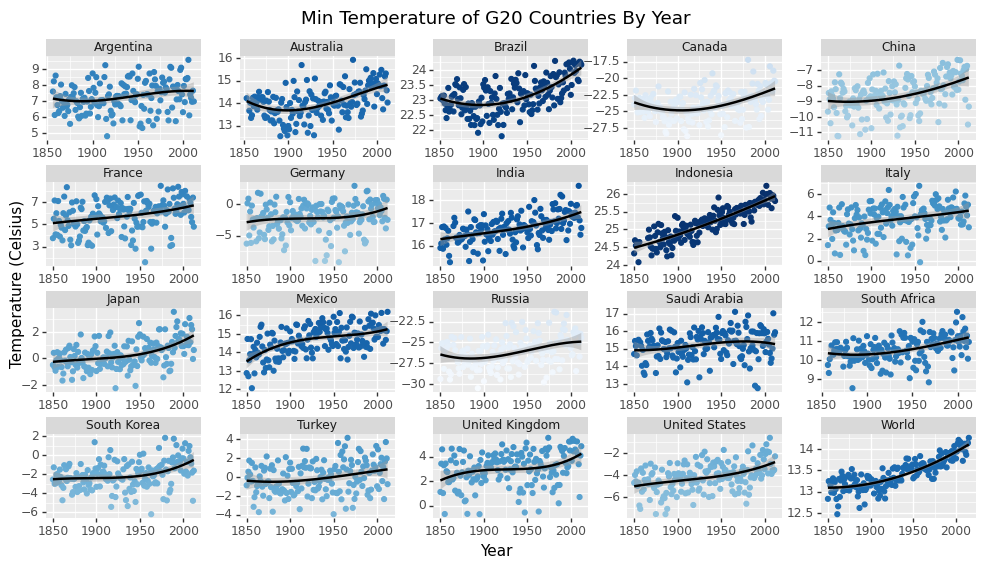

<ggplot: (175118900827)>

In [265]:
(ggplot((df.groupby(['year', 'country'])
           .filter(lambda x: len(x) == 12)
           .groupby(['year', 'country'])
           .agg({'average_temperature': 'min'})
           .reset_index()
))  + aes(x='year', y='average_temperature', color='average_temperature')
    + geom_point()
    + geom_smooth(method = 'lm', formula = 'y ~ x + I(x**2) + I(x**3) + I(x**4)', se = True)
    + facet_wrap('~country', scales = "free")
    + scale_color_cmap('Blues')
    + labs(title='Min Temperature of G20 Countries By Year', x='Year', y='Temperature (Celsius)')
    + theme(figure_size=(12, 6), subplots_adjust={'wspace': 0.25, 'hspace': 0.5}, legend_position='none')
)

## 1.5 Analysis on US States

In this section, we hope to zooming in further and look at how temperature has changed over time in the United States. We use color to denote the temperature each year for each state in the US. Red suggests a state's mean temperature is high and above zero, while blue means that the temperature is cold and below zero.

### 1.5.1 Temperatures by State

In the graph below, we use an animation to show how the average annual temperature has changed from 1850 to 2012. We can see that the states in the South generally have higher average temperature regardless of the year than states in the North. From the animation, it is hard to determine whether the average temperature of states have changed over time. However, if we compare the color of states between year 1850 and 2012, we can see that there are some very subtle changes. For example, the color of the Texas changes from orange to a darker orange, and the color of New York changes from light blue to light orange. 

In [266]:
df = (DF_state.copy(deep = True)
              .dropna()
              .query('year >= 1850 and country == "United States"')
              .loc[:, ['state', 'year', 'month', 'average_temperature']]
              .groupby(['year', 'state'])
              .filter(lambda x: len(x) == 12)
              .groupby(['year', 'state'])
              .agg({'average_temperature': 'mean'})
              .reset_index())

df["state"] = df["state"].apply(lambda x: "Georgia" if x == "Georgia (State)" else x)
df["state"] = df["state"].apply(lambda x: us.states.lookup(x).abbr)

In [267]:
fig = px.choropleth(df,
                    locations="state",
                    animation_frame = "year", #  
                    locationmode='USA-states',
                    scope="usa",
                    color="average_temperature",
                    range_color = [-10, 30],
                    hover_name="state",
                    title = 'Average Annual Temperature in the United States (1850-2012)',
                    color_continuous_scale = 'RdBu_r') 

fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 1

fig.show()

### 1.5.2 Absolute Temperature Change by State

In the graph below, we show that the absolute change of average temperature for all states between the first decade of 20th century and the most recent decade. The redder the graph, the more temperature has increased in the last hundred years. Interestingly, we see that the states closer to the Northeast experienced higher temperature increase than states in the West. For example, the average temperature of Maine increases around 1.84 Celsius in the last hundred years, while that of California increases around 0.75 Celsius. It is unclear why temperature changes in an unbalanced manner within the United States. 

In [268]:
past_df = (df.query('year >= 1900 and year < 1910')
             .groupby('state')
             .agg({'average_temperature': 'mean'}))

present_df = (df.query('year >= 2006 and year <= 2015')
                .groupby('state')
                .agg({'average_temperature': 'mean'}))

df = pd.merge(past_df, present_df, on = 'state')
df['change'] = df['average_temperature_y'] - df['average_temperature_x']

df.reset_index(inplace = True)

In [269]:
fig = px.choropleth(df,
                    locations="state",
                    locationmode='USA-states',
                    scope="usa",
                    color="change",
                    range_color = [0, 2],
                    hover_name="state",
                    color_continuous_scale = 'reds',
                    title = 'Average Temperature Change in the US (1900-1910 vs 2006-2015)')

fig.show()

### 1.5.3 Absolute Temperature Change by State (Word Cloud)

In the WordCloud, we display US states with larger change of average temperature over the last hundred of years with larger texts. For example, we can clearly see that Vermont has the largest temperature increase. 

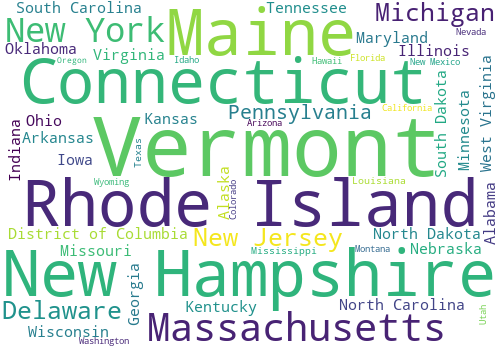

In [270]:
df["state"] = df["state"].apply(lambda x: us.states.lookup(x).name)

cnt = Counter({k:int(v*1000) for k, v in zip(df["state"], df["change"])})

wordcloud = WordCloud(background_color = 'white',
                       width = 500,
                       height = 350
                      ).generate_from_frequencies(cnt).to_image()
wordcloud

## 1.6 Time Series Analysis

In this section, we use the global land average temperature as proxy to explore the time series characteristics of the data.

In [271]:
df =(DF_global.copy(deep = True)
              .rename(columns = {'land_average_temperature': 'average_temperature'})
              .query('year >= 1850')
)

### 1.6.1 Trend
Since we want to model the data on a monthly basis, we plot the monthly average temperature over time. 

Here, we use the color to denote the month; we make two observations here:
1. There is a clear and consistent correlation between the month and the temperature; this is reflected in the color stratificaiton in the plot below.
2. There is an increasing trend in the Year-on-Year monthly average temperatures (i.e. the twelfth difference of the monthly average temperature), and this trend itself is accelerating: pick a random color and connect the dots, and you will find a curve that is increasingly increasing.

In [272]:
fig = px.scatter(df, x="dt", y="average_temperature",
                title = 'Global Land Monthly Average Temperature Since 1850',
                color = "month", 
                color_continuous_scale = "Portland",
                width = 800, height = 600)
fig.show()

### 1.6.2 Seasonality

Here, we briefly look at seasonality in the data. While we are already aware of the correlation between the month and the temperature, it behooves to inspect visually the yearly cycle. To this end, we plot the monthly average temperature since 2010, and we see that the temperature is highest in July and August, and lowest in January and February. The "sinusoidal" shape of the plot is a clear indication of seasonality, and the pattern is similar across the years, with some slight fluctuations of course.

In [273]:
fig1 = px.line(df.query('year >= 2010'),
                x="dt", y="average_temperature",
                title = 'Global Land Monthly Average Temperature Since 2010',
                width = 800, height = 600)

fig1.show()

### 1.6.3 Autocorrelation

We can inspect seasonality also with an ACF plot as belows; the plot shows the autocorrelation of the monthly average temperature from 1, 2, 3, ... months ago.

We take two main conclusions from this plot:
- The monthly temperatures fluctuates in a sinusoidal pattern, where the length of the cycle is 12 months.
- `month` is a highly potent predictor of `land_average_temperature`, and this is reflected in the high autocorrelation at lag 12, lag 24, etc. The effects are waning, which makes sense: the temperature from the past year is more relevant than the temperature from the year before that.

Also, this could be an indicator of unit root in the data, suggesting that the data could be modeled with a random walk with drift, but we won't read too much into this.

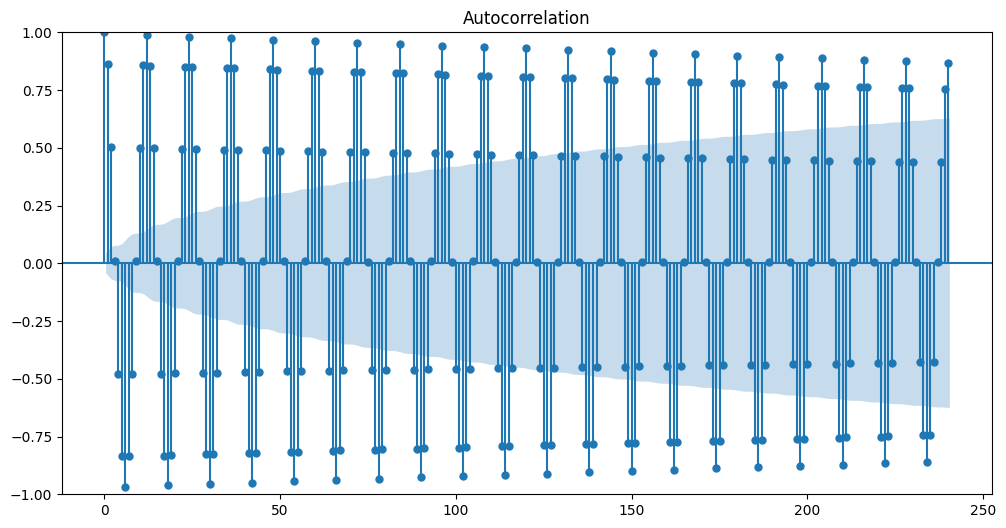

In [274]:
plt.rcParams['figure.figsize'] = [12, 6]

_ = plot_acf(df["average_temperature"].values, lags = 240);

plt.show()

### 1.6.4 Partial Autocorrelation

PACF plot is another tool to inspect seasonality. The PACF plot shows the partial autocorrelation of the monthly average temperature from 1, 2, 3, ... months ago. The partial autocorrelation is the correlation between the temperature at time `t` and the temperature at time `t-k` after removing the effect of the temperature at time `t-1`, `t-2`, ..., `t-(k-1)`.

We specify the estimation method to be `ywmle` (i.e. Yule-Walker Maximum Likelihood Estimator) here; by default, because our sample size is small, the library `statsmodels` uses `ymadjusted` (which performs an adjustment for sample size). We found that this adjustment yields terrible results.

The results here are intuitive. If I know the temperatures from this month, last month, ..., knowing the temperatures further back would not help me predict the temperature next month. This is reflected here in the small values at higher lags, in direct juxtaposition to what we saw in the ACF plot.

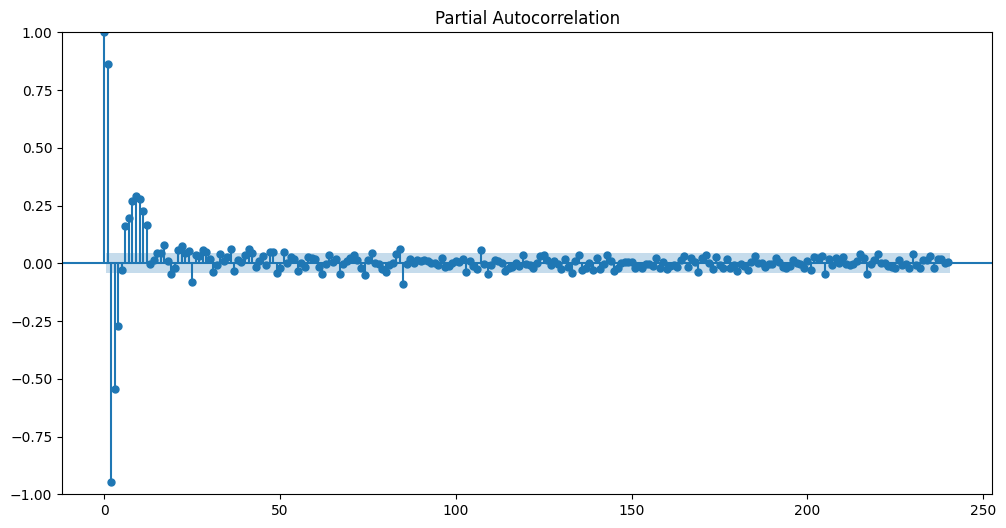

In [275]:
_ = plot_pacf(df["average_temperature"].values, lags = 240, method = "ywmle");

plt.show()

### 1.6.5 Differencing

Let's experiment a bit with differencing here. We will use the ACF plot to interpret what the differencing operation achieved.

We know that there is a yearly cycle in the data, so let's start with a 12-th order differencing. 

We see that the higher lags are no longer significant, but the lags at 1, 2, 3, 4, 11, 12, 13 are still significant. The large negative value at lag 12 indicates an overcorrection from the differencing.

There is still a sinusodal pattern in the plot, so a 12-th order differencing is insufficient to remove the seasonality. This is not surprising. What we have done here is a year-over-year differencing, and knowing that there was an increase between June 2010 and June 2011 would be weakly informative about what happens between June 2015 and June 2016, at least more so that the differences in other months.

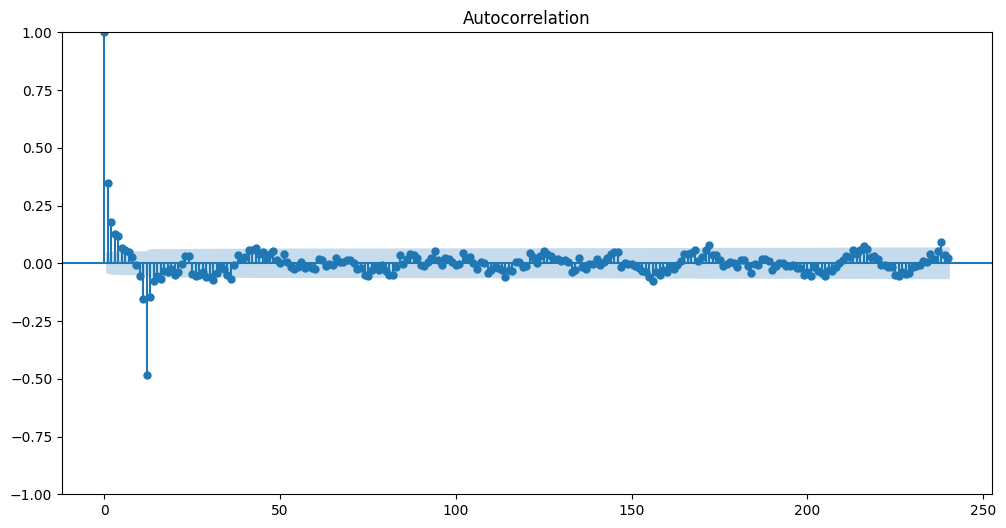

In [276]:
_ = plot_acf(df["average_temperature"].diff(12).dropna().values, lags = 240);

plt.show()

Let's see what a 1-th order differencing in addition to the 12-th order differencing would do.

We see that there is a bit of an overcorrection at lag 1 and lag 12, but other than this, the seasonal structure is dealt with, and most lags are no longer significant.

In ARIMA terminology, it seems that something like $\text{SARIMA}(\cdot, 1, \cdot)(\cdot, 1, \cdot)_{12}$ could fit the data well.

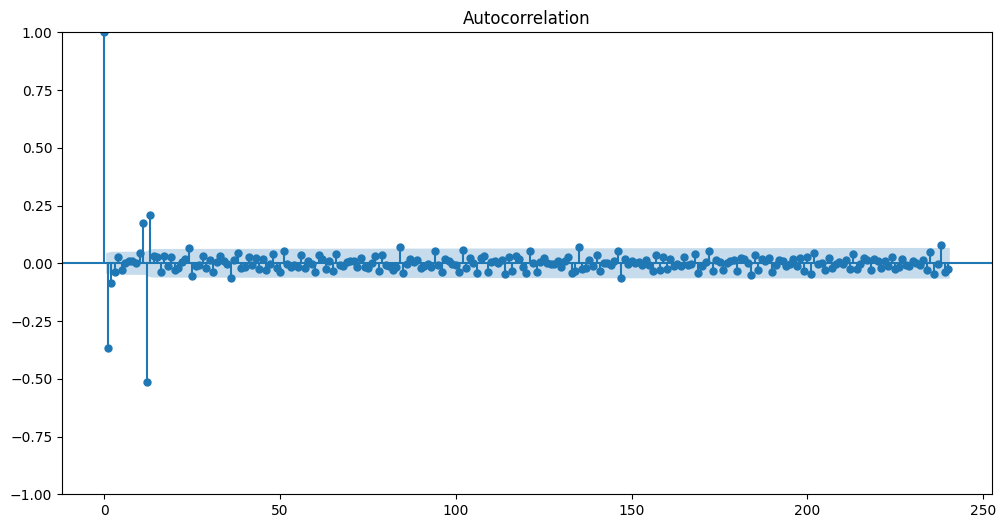

In [277]:
_ = plot_acf(df["average_temperature"].diff(12).diff().dropna().values, lags = 240);

plt.show()

# 2 Predictive Modeling

What we have learnt so far is that:
1. Geography is informative of temperatures: the temperatures of different regions are different and changes at different rates.
2. There is a seasonal component in the monthly data, and lag temperatures are  predictive.

We would like to build machine learning models that can capture these two aspects, and we will have to do some further feature engineering to do so. We will be building model with `DF_city`, as it contains about 9 million rows, which is too good to not play around with. 

Based on our time series analysis, making the monthly temperatures stationary is challenging: the seasonality is hard to deal with, and there are issues with trend and unit root. Instead of worrying about stationarity with the monthly data, we will be modeling on yearly data. This is binning, which removes the seasonality.

We will perform a first difference on the yearly temperatures for stationarity and incorporate the geographical information into the model. Twelve lag years of temperatures will be used.

We will be using a variety of models here, including:
1. For linear specificions: linear regression, Bayesian Ridge.
2. For tree specifications: random forest, CatBoost.
3. For neural network specifications: MLP, CNN.

To have a way of evaluating our models, we use all data after 1850 and before 2000 as training data, and all data after 2000 as test data.

Before doing any feature engineering or modelling, let's split the data into training and test sets.

In [278]:
df = DF_city.dropna()
# training data: temperature data from 1850 to 1999 in available cities
df_train = df.query('year > 1850 and year < 2000') # 1999 is last year that is used as "y"
# training data: temperature data from 2000 till now in available cities
df_val = df.query('year >= 1999') # 2000 is the first year that we can forecast

Also, we will set up an empty dictionary to store the out-of-sample residuals of our models to faciliate comparisons.

In [279]:
# empty dict storing out-of-sample residuals
residual_dict = {}

## 2.1 Feature Engineering

### 2.1.1 Convert Latitude and Longitude to Categorical

To begin with, we convert the latitude and longitude into integers; to not introduce too much noise, we choose 10 bins for latitude ($180^\circ$) and 20 bins for longitude ($360^\circ$). Instead of setting fixed width of some degrees (which is not a good idea, since cities are usually clustered within a small degrees), we let each bin contain the same amount of cities.

We use ordinal encoding now and change to one-hot encoding when necessary.


In [280]:
# creating 20 bins for cities according to its longtitude
longitude_binner = KBinsDiscretizer(n_bins = 20, 
                                    encode = 'ordinal', 
                                    strategy = 'quantile')

# creating 10 bins for cities according to its latitude
latitude_binner = KBinsDiscretizer(n_bins = 10,
                                   encode = 'ordinal',
                                   strategy = 'quantile')

df_train["longitude"] = longitude_binner.fit_transform(df_train[["longitude"]]).astype(np.int8)
df_train["latitude"] = latitude_binner.fit_transform(df_train[["latitude"]]).astype(np.int8)

df_val["longitude"] = longitude_binner.transform(df_val[["longitude"]]).astype(np.int8)
df_val["latitude"] = latitude_binner.transform(df_val[["latitude"]]).astype(np.int8)

In [281]:
# select training and testing data that has temperature data on record for 12 month in a year
# compute average temperature in a year
df_train = (df_train.groupby(['year', 'country', 'city', 'latitude', 'longitude'])
                    .filter(lambda x: len(x) == 12)
                    .groupby(['year', 'country', 'city', 'latitude', 'longitude'])
                    .agg({'average_temperature': 'mean'})
                    .reset_index())

df_val = (df_val.groupby(['year', 'country', 'city', 'latitude', 'longitude'])
                .filter(lambda x: len(x) == 12)
                .groupby(['year', 'country', 'city', 'latitude', 'longitude'])
                .agg({'average_temperature': 'mean'})
                .reset_index())

### 2.1.2 Create Time Series Features & Target

Here, we let $y_{i,t}$ be the average temperature, and let $\Delta y_{i, t} \coloneqq y_{i,t} - y_{i,t-1}$ be the first difference of the average temperature.

Whilst unconventional, we want to create a column where for city $i$ and time $t$, it takes as value an np.array of the form:
$$
\begin{gathered}
[\Delta y_{i, t-12},
 \Delta y_{i, t-11},  
 \dots,
 \Delta y_{i, t-1}
]
\end{gathered}
$$
- (12, ) - (time, )

This is the feature that we will feed into our neural networks, and it is quite convenient to make this transformation; as an aside, when we have a np.array in a dataframe, we can store this it using `feather` format, which is much faster and far more space efficient than `pickle` or `csv`.

As a conclusion, we will have the following new columns:
- `lead_temperature`: (1)
- `temperature_ts`: (12,)

In [282]:
# we create a sliding window function that prepends (window - 1) np.nan values to the beginning of the array
# before doing the sliding and striding

# much like what we did in class for ngrams to calculating Jaccard similarity
# this is just to make sure that if we pass an array of length 12
# and for a window size of 3, we get an array of shape (12, 3)

def sliding_window(a, window = 12): 
    # a is 2D array
    if a.ndim == 2:
        a = np.concatenate([np.full((window - 1, a.shape[1]), np.nan), a], axis = 0)

        shape = (a.shape[0] - window + 1, window, a.shape[1])
        strides = (a.strides[0], a.strides[0], a.strides[1])
    else:
        a = np.concatenate([np.full(window - 1, np.nan), a], axis = 0)

        shape = (a.shape[0] - window + 1, window)
        strides = (a.strides[0], a.strides[0])

    return np.lib.stride_tricks.as_strided(a, shape = shape, strides = strides)


# Test 1: 1D array
a = np.arange(5)

expected = np.array([[np.nan, np.nan, 0],
                     [np.nan, 0, 1],
                     [0, 1, 2],
                     [1, 2, 3],
                     [2, 3, 4]])

np.testing.assert_array_equal(sliding_window(a, window = 3), expected, "1D array test failed")

# Test 2: 2D array
a = np.stack([np.arange(3), np.arange(1, 4)], axis = 1)

expected = np.array([[[np.nan, np.nan], [np.nan, np.nan], [0, 1]],
                        [[np.nan, np.nan], [0, 1], [1, 2]],
                        [[0, 1], [1, 2], [2, 3]]])

np.testing.assert_array_equal(sliding_window(a, window = 3), expected, "2D array test failed")

In [283]:
# contains all possible dates
# we will expand our dataframs with this template, so that we can detect missing values efficiently
df_template = pd.DataFrame({
        'year': list(np.arange(1850, 2000)),
})


# as our operations are complex, we will use an explicit for loop here.

list_of_dfs = []

for (city, country), group_df in tqdm(df_train.groupby(['city', 'country'])):
        # expand the dataframe
        group_df = group_df.merge(df_template, on = 'year', how = 'right')

        # perform first difference
        group_df["average_temperature"] = group_df["average_temperature"].diff(1)

        # get the sliding windows for features 
        array = group_df["average_temperature"].values
        group_df["temperature_ts"] = list(sliding_window(array)) 

        # Currently, for each time (row) t, the most recent entry in each ts is the value at t
        # We want the most recent entry to be the value at t - 1 (otherwise, we are just using the value at t to predict t)
        # so we shift all the ts by 1

        group_df['temperature_ts'] = group_df['temperature_ts'].shift(1)

        # `average_temperature` is now our target and we rename it to `lead_temperature`
        group_df = group_df.rename(columns = {'average_temperature': 'lead_temperature'})


        # Now we deal with missing values
        
        # we begin by a simple dropna
        # this drops all rows where "average_temperature" (which is now our target) is missing
        group_df = group_df.dropna() # unfortunately, pandas cannot detect the na values in the ts

        if len(group_df) == 0: # do not bother with empty dataframes further
                continue

        # next, we deal with missing values in the ts
        mask = group_df['temperature_ts'].apply(lambda x: np.isnan(x).any())
        group_df = group_df[~mask]
                
        if len(group_df) == 0: # do not bother with empty dataframes further
                continue

        # finally, we add this dataframe to our list
        list_of_dfs.append(group_df)

# concatenate all the dataframes in the list
df_train = pd.concat(list_of_dfs)

del list_of_dfs; gc.collect();

100%|██████████| 3489/3489 [00:09<00:00, 375.39it/s]


In [284]:
# now we repeat the same process for the validation set

# contains all possible dates
# we will expand our dataframs with this template, so that we can detect missing values efficiently
df_template = pd.DataFrame({
        'year': list(np.arange(1988, 2020)), # it's fine if we have excess
})


# as our operations are complex, we will use an explicit for loop here.

list_of_dfs = []

for (city, country), group_df in tqdm(df_val.groupby(['city', 'country'])):
        # expand the dataframe
        group_df = group_df.merge(df_template, on = 'year', how = 'right')

        # perform first difference
        group_df["average_temperature"] = group_df["average_temperature"].diff(1)

        # get the sliding windows for features 
        array = group_df["average_temperature"].values
        group_df["temperature_ts"] = list(sliding_window(array)) 

        # Currently, for each time (row) t, the most recent entry in each ts is the value at t
        # We want the most recent entry to be the value at t - 1 (otherwise, we are just using the value at t to predict t)
        # so we shift all the ts by 1

        group_df['temperature_ts'] = group_df['temperature_ts'].shift(1)

        # `average_temperature` is now our target and we rename it to `lead_temperature`
        group_df = group_df.rename(columns = {'average_temperature': 'lead_temperature'})


        # Now we deal with missing values
        
        # we begin by a simple dropna
        # this drops all rows where "average_temperature" (which is now our target) is missing
        group_df = group_df.dropna() # unfortunately, pandas cannot detect the na values in the ts

        if len(group_df) == 0: # do not bother with empty dataframes further
                continue

        # next, we deal with missing values in the ts
        mask = group_df['temperature_ts'].apply(lambda x: np.isnan(x).any())
        group_df = group_df[~mask]
                
        if len(group_df) == 0: # do not bother with empty dataframes further
                continue

        # finally, we add this dataframe to our list
        list_of_dfs.append(group_df)

# concatenate all the dataframes in the list
df_val = pd.concat(list_of_dfs)

del list_of_dfs; gc.collect();

100%|██████████| 3489/3489 [00:07<00:00, 437.44it/s]


## 2.2. Linear Specifications

We first consider a linear specification. This can be think as baseline models. Note that OLS here is $\text{ARIMA}(12, 1, 0)$ on the yearly data.

### 2.2.1 Data Preparation

The twelve lagged temperatures can be used by linear models as is, but the latitude and longitude will need to be one-hot encoded. We perform this below and acquire `X_train`, `X_val`, `y_train`, and `y_val` in standard convention.

In [285]:
# stack up all temperature data
temperatures_train = np.stack(list(df_train["temperature_ts"].values), axis = 0)
temperatures_val = np.stack(list(df_val["temperature_ts"].values), axis = 0)

# one-hot encoding for latitude data
latitudes_train = to_categorical(df_train["latitude"].values, num_classes = 10)
latitudes_val = to_categorical(df_val["latitude"].values, num_classes = 10)

# one-hot encoding for longtitude data
longitudes_train = to_categorical(df_train["longitude"].values, num_classes = 20)
longitudes_val = to_categorical(df_val["longitude"].values, num_classes = 20)

# concatenate temperatures_train, latitudes_train, longitudes_train to form final training/testing dataset
X_train = np.concatenate([temperatures_train, latitudes_train, longitudes_train], axis = 1)
X_val = np.concatenate([temperatures_val, latitudes_val, longitudes_val], axis = 1)

# set lead_tempearture as target values
y_train = df_train["lead_temperature"].values
y_val = df_val["lead_temperature"].values

### 2.2.2 Ordinary Least Squares

Here we fit an OLS model. As mentioned before, this is $\text{ARIMA}(12, 1, 0)$ on the yearly data.


In [286]:
model = LinearRegression().fit(X_train, y_train) # Create Linear Regression model and train on training data

y_pred = model.predict(X_val) # Apply the model to testing data

residual = y_val - y_pred # Calculate residual

residual_dict["OLS"] = residual # Store residual to dictionary

### 2.2.3 Bayesian Ridge Regression

Bayesian Ridge Regression imposes a normal prior on the coefficients and performs Bayesian inference; the effect of this is exactly similar to the normal Ridge Regression, with the scale parameter on the normal prior corresponding to the regularization parameter in Ridge. We use Bayesian Ridge here, because in `sklearn`'s implementation, a hyperprior is imposed over the scale parameter, and the parameter is jointly optimized with the coefficients. This just means that we get automatic hyperparameter tuning for free; tuning the regularization parameter on Ridge would have required a laborious grid search, not to mention a rolling cross-validation to be implemented.

In [287]:
model = BayesianRidge().fit(X_train, y_train) # Create Bayesian Ridge model and train on training data

y_pred = model.predict(X_val) # Apply the model to testing data

residual = y_val - y_pred # Calculate residual

residual_dict["Bayesian Ridge"] = residual # Store residual to dictionary

## 2.3 Tree Specifications

Tree specifications are more flexible than linear specifications, and we will be using them to capture the non-linearities in the data; here we consider random forest, which uses bagging, and CatBoost, which uses boosting. The default hyperparameters are used for both models.

### 2.3.1 Data Preparation

The twelve lagged temperatures can be used as-is, and we do not need to one-hot encode the latitude and longitude. Tree specifications can handle ordinal encoding natively.


In [288]:
X_train = np.stack(list(df_train["temperature_ts"].values), axis = 0)
X_train = np.concatenate([X_train, df_train[["latitude", "longitude"]].values], axis = 1)

X_val = np.stack(list(df_val["temperature_ts"].values), axis = 0)
X_val = np.concatenate([X_val, df_val[["latitude", "longitude"]].values], axis = 1)

y_train = df_train["lead_temperature"].values
y_val = df_val["lead_temperature"].values

### 2.3.2 Random Forest

Here we fit a random forest model using the default hyperparameters. By default, `sklearn` uses 100 trees, with a min sample split of 2 and no maximum depth limitations. Note that we cannot use the out-of-bag error to evaluate the model, as the data is not iid (time series).

In [289]:
model = RandomForestRegressor(random_state = 42, # set random seed
                              n_jobs = -1).fit(X_train, y_train) # Create Random Forest model and train on training data

y_pred = model.predict(X_val) # Apply the model to testing data

residual = y_val - y_pred # Calculate residual

residual_dict["Random Forest"] = residual # Store residual to dictionary

### 2.3.3 CatBoost

Here we fit a CatBoost model using the default hyperparameters. By default, 1000 boosting iterations are used, and each tree has a maximum depth of 6. CatBoost automatically selects the learning rate schedule and is in general very robust to hyperparameter (the defualt hyperparameters are pretty good).

In [290]:
model = CatBoostRegressor(task_type = "GPU", # use GPU to speed up training
                          random_state = 42, # set random seed
                          verbose = 0).fit(X_train, y_train) # Create CatBoost model and train on training data

y_pred = model.predict(X_val) # Apply the model to testing data

residual = y_val - y_pred # Calculate residual

residual_dict["CatBoost"] = residual # Store residual to dictionary

## 2.4 Neural Network

Neural networks are another nonlinear machine learning method we have at our disposal. Here, wew will be using a multi-layer perceptron (MLP) and a convolutional neural network (CNN). Note that we are using one-dimensional CNN as opposed to two-dimensional CNN that we saw in class: the difference is only in that instead of using a "sqaure" kernel, we use a "line" kernel (window). 

### 2.4.1 Data Preparation

We prepate the dataset for the neural networks in the same way as we did for the tree specifications. The integer encoding of the latitude and longitude will map to trainable embeddings in the neural networks, so we do not need to one-hot encode them.

In [291]:
class MLPDataset(Dataset):
    def __init__(self, df):
        self.temperature = np.array([x.flatten() for x in df["temperature_ts"].values]).astype(np.float32)
        self.latitude = df["latitude"].values.astype(np.int64)
        self.longitude = df["longitude"].values.astype(np.int64)

        self.target = df["lead_temperature"].values.astype(np.float32)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        temperature = self.temperature[idx]
        latitude = self.latitude[idx]
        longitude = self.longitude[idx]
        target = self.target[idx]

        return temperature, latitude, longitude, target
    
train_dataset = MLPDataset(df_train)
val_dataset = MLPDataset(df_val)

train_loader = DataLoader(train_dataset, batch_size = 512, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 512, shuffle = False)

### 2.4.2 Training and Inference Functions

Here we define routine functions. `train` trains the model for one epoch. `evaluate` returns the validation loss.

In [292]:
def train(model, train_loader, optimizer, criterion, device):
    model.train() # prep model for training
    train_loss = 0 # initialize the training loss
    for temperature, latitude, longitude, target in train_loader:
        temperature = temperature.to(device)
        latitude = latitude.to(device)
        longitude = longitude.to(device)
        target = target.to(device) 

        optimizer.zero_grad() # clear gradients for this training step

        output = model(temperature, latitude, longitude) # get output for every training data

        loss = criterion(output.flatten(), target.flatten()) # calculate loss for every training data

        loss.backward() # backpropagation, compute gradients
        optimizer.step() # apply gradients

        train_loss += loss.item() # sum up batch loss

    train_loss /= len(train_loader) # calculate average loss

    return train_loss

def evaluate(model, val_loader, criterion, device):
    model.eval() # prep model for evaluation
    val_loss = 0
    with torch.no_grad(): # turn off gradient calculation
        for temperature, latitude, longitude, target in val_loader:
            temperature = temperature.to(device)
            latitude = latitude.to(device)
            longitude = longitude.to(device)
            target = target.to(device)

            output = model(temperature, latitude, longitude) 

            loss = criterion(output.flatten(), target.flatten()) # calculate loss for every validation data

            val_loss += loss.item() # sum up batch loss
     
    val_loss /= len(val_loader) # calculate average loss

    return val_loss

### 2.4.2 Multiple Layer Perceptron (MLP)

We decide on a three-layed feed-forward neural network. We use ReLU for nonlinearities, Adam for fast convergence, and decoupled weight decay for regularization. We handle the categorical longitude and latitude by embedding them into a lower dimensional space (which is trainable!).

In [293]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 10 bins -> 8-dim embedding
        self.embedding_lat = nn.Embedding(10, 8)
        # 20 bins -> 8-dim embedding
        self.embedding_long = nn.Embedding(20, 8)

        # fc 1
        # input_dim = 8 * 2 (embeddings) + 12 (temperature) = 28
        # output_dim = 32
        self.fc1 = nn.Linear(8 * 2 + 12, 32)
        self.ac1 = nn.ReLU()
        
        # fc 2
        # input_dim = 32
        # output_dim = 16
        self.fc2 = nn.Linear(32, 16)
        self.ac2 = nn.ReLU()

        # fc 3
        # input_dim = 16
        # output_dim = 8
        self.fc3 = nn.Linear(16, 8)
        self.ac3 = nn.ReLU()

        # output
        # input_dim = 8
        # output_dim = 1
        self.out = nn.Linear(8, 1)

    def forward(self, temperature, latitude, longitude):
        # get the embeddings
        latitude = self.embedding_lat(latitude)
        longitude = self.embedding_long(longitude)

        # concatenate the embeddings and the temperature
        x = torch.cat([latitude, longitude, temperature], dim = 1)

        # pass through the layers
        x = self.fc1(x)
        x = self.ac1(x)

        x = self.fc2(x)
        x = self.ac2(x)

        x = self.fc3(x)
        x = self.ac3(x)

        x = self.out(x)

        return x

In [294]:
device = "cuda" if torch.cuda.is_available() else "cpu" # setup GPU
model = MLP().to(device) # send model to GPU

# we use AdamW optimizer with weight decay
# weight decay is a regularization technique
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4, weight_decay = 1e-1)

# we use mean squared error loss
criterion = nn.MSELoss(reduction="mean").to(device)

# containers for training and validation loss
MLP_TRAIN_LOSS = []
MLP_VAL_LOSS = []

# training loop
for epoch in range(10):
    # train for one epoch
    train_loss = train(model, train_loader, optimizer, criterion, device)

    # evaluate on validation set
    val_loss = evaluate(model, val_loader, criterion, device)

    # store the loss
    MLP_TRAIN_LOSS.append(train_loss)
    MLP_VAL_LOSS.append(val_loss)
    
    print(f"Epoch {epoch + 1} - Train loss: {train_loss} - Val loss: {val_loss}")

Epoch 1 - Train loss: 0.48973586400054414 - Val loss: 0.2991822883486748
Epoch 2 - Train loss: 0.26721255382356707 - Val loss: 0.24422382190823555
Epoch 3 - Train loss: 0.24678881578914633 - Val loss: 0.23888524994254112
Epoch 4 - Train loss: 0.23683540908368284 - Val loss: 0.2228676788508892
Epoch 5 - Train loss: 0.23122887956127694 - Val loss: 0.23003887757658958
Epoch 6 - Train loss: 0.22741221827486832 - Val loss: 0.2532775718718767
Epoch 7 - Train loss: 0.22438119015991007 - Val loss: 0.23436107486486435
Epoch 8 - Train loss: 0.22149131314091605 - Val loss: 0.2307686898857355
Epoch 9 - Train loss: 0.21915758726798698 - Val loss: 0.2356172874569893
Epoch 10 - Train loss: 0.2169278232333862 - Val loss: 0.23405507765710354


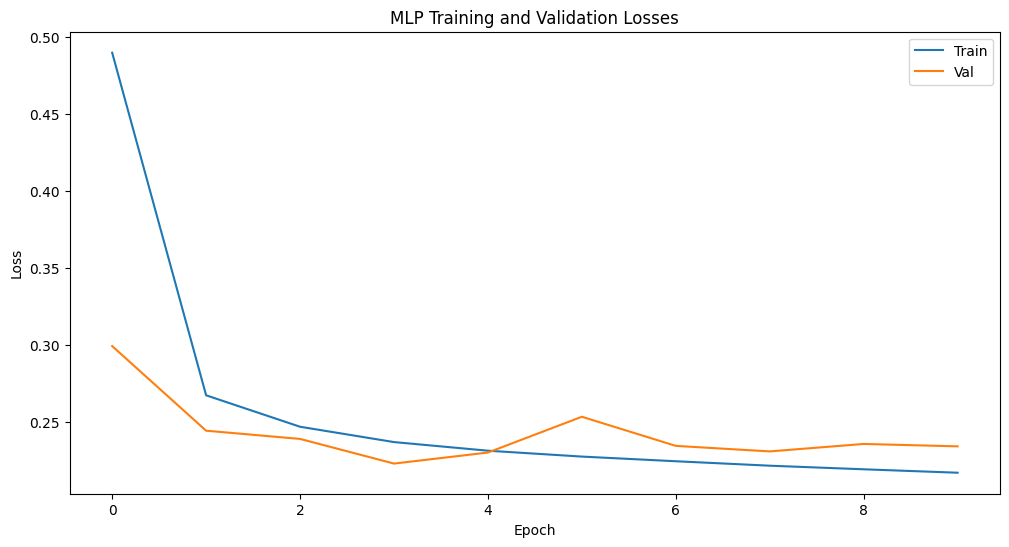

In [295]:
# plot the losses
plt.plot(MLP_TRAIN_LOSS, label = "Train")
plt.plot(MLP_VAL_LOSS, label = "Val")
plt.legend()

# add title
plt.title("MLP Training and Validation Losses")

# add x and y labels
plt.xlabel("Epoch")
plt.ylabel("Loss")

# show the plot
plt.show()

In [296]:
# get the predictions
y_pred = None
y_true = None

model.eval()
with torch.no_grad():
    for temperature, latitude, longitude, target in val_loader:
        temperature = temperature.to(device)
        latitude = latitude.to(device)
        longitude = longitude.to(device)
        target = target.to(device)

        # get the predictions
        output = model(temperature, latitude, longitude)

        # store the predictions
        if y_pred is None:
            y_pred = output.cpu().detach().numpy()
            y_true = target.cpu().detach().numpy()
        else:
            y_pred = np.concatenate((y_pred, output.cpu().detach().numpy()), axis = 0)
            y_true = np.concatenate((y_true, target.cpu().detach().numpy()), axis = 0)

# add the residuals to the dictionary
residual_dict["MLP"] = y_true.flatten() - y_pred.flatten()

### 2.4.3 Convolutional Neural Network (CNN)

Our CNN implementation follows what we have seen in class, with the salient exception that we use one-dimensional convolutional layers. We use ReLU for nonlinearities, Adam for fast convergence, and decoupled weight decay for regularization. Batch normalization is used after each convolutional layer (specificationally, after the activation function); this helps to stabilize the training process and maybe help with overfitting (the exact effect is not well understood). We handle the categorical longitude and latitude by embedding them into a lower dimensional space (which is trainable!).



In [297]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 10 bins -> 8-dim embedding
        self.embedding_lat = nn.Embedding(10, 8)
        # 20 bins -> 8-dim embedding
        self.embedding_long = nn.Embedding(20, 8)

        # conv 1
        # input_dim = (1, 12) - channel first
        # output_dim = (32, 12)
        self.conv1 = nn.Conv1d(1, 32, kernel_size = 3, padding = 1)
        self.ac1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(32)

        # conv 2
        # input_dim = (32, 12)
        # output_dim = (64, 12)
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, padding = 1)
        self.ac2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(64)

        # global average pooling
        # input_dim = (64, 12)
        # output_dim = (64, 1)
        self.gap = nn.AdaptiveAvgPool1d(1)

        # flatten
        # input_dim = (64, 1)
        # output_dim = (64)
        self.flatten = nn.Flatten()

        # fc 1
        # input_dim = 64 + 8 * 2 (embeddings)
        # output_dim = 32
        self.fc1 = nn.Linear(64 + 8 * 2, 32)
        self.ac3 = nn.ReLU()

        # fc 2
        # input_dim = 32
        # output_dim = 16
        self.fc2 = nn.Linear(32, 16)
        self.ac4 = nn.ReLU()

        # output
        # input_dim = 16
        # output_dim = 1
        self.out = nn.Linear(16, 1)

    def forward(self, temperature, latitude, longitude):
        # get the embeddings
        latitude = self.embedding_lat(latitude)
        longitude = self.embedding_long(longitude)

        # reshape the temperature
        temperature = temperature.unsqueeze(1)

        # pass through the layers
        x = self.conv1(temperature)
        x = self.ac1(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.ac2(x)
        x = self.bn2(x)

        x = self.gap(x)
        x = self.flatten(x)

        x = torch.cat([x, latitude, longitude], dim = 1)

        x = self.fc1(x)
        x = self.ac3(x)

        x = self.fc2(x)
        x = self.ac4(x)

        x = self.out(x)

        return x

In [298]:
device = "cuda" if torch.cuda.is_available() else "cpu" # set GPU

model = CNN().to(device) # send model to GPU
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4, weight_decay = 1e-1)

criterion = nn.MSELoss(reduction="mean").to(device) 

CNN_TRAIN_LOSS = []
CNN_VAL_LOSS = []

for epoch in range(10):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    CNN_TRAIN_LOSS.append(train_loss)
    CNN_VAL_LOSS.append(val_loss)

    print(f"Epoch {epoch + 1} - Train loss: {train_loss} - Val loss: {val_loss}")

Epoch 1 - Train loss: 0.4216775290275875 - Val loss: 0.27764781191945076
Epoch 2 - Train loss: 0.26530616575302196 - Val loss: 0.2766659874469042
Epoch 3 - Train loss: 0.25167703814378317 - Val loss: 0.25529464706778526
Epoch 4 - Train loss: 0.24543960109455362 - Val loss: 0.24808445572853088
Epoch 5 - Train loss: 0.2403476452902471 - Val loss: 0.26175100542604923
Epoch 6 - Train loss: 0.2352658335451949 - Val loss: 0.2616798896342516
Epoch 7 - Train loss: 0.22987285077367275 - Val loss: 0.3008005265146494
Epoch 8 - Train loss: 0.22738536022756956 - Val loss: 0.2671109400689602
Epoch 9 - Train loss: 0.22251755135555834 - Val loss: 0.2660363186150789
Epoch 10 - Train loss: 0.21862270619967436 - Val loss: 0.2681012749671936


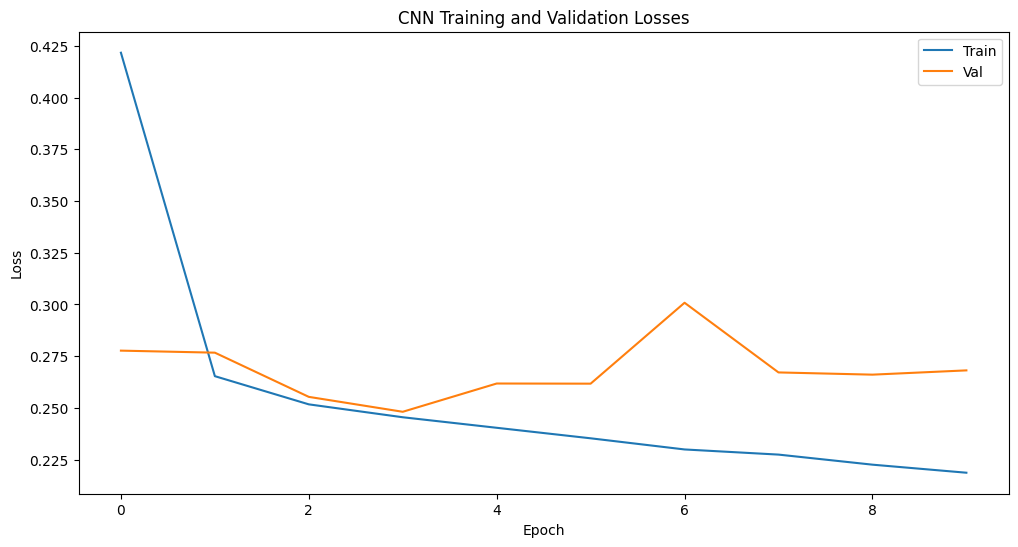

In [299]:
# plot the losses
plt.plot(CNN_TRAIN_LOSS, label = "Train")
plt.plot(CNN_VAL_LOSS, label = "Val")
plt.legend()

# add title
plt.title("CNN Training and Validation Losses")

# add x and y labels
plt.xlabel("Epoch")
plt.ylabel("Loss")

# show the plot
plt.show()

In [300]:
# get the predictions
y_pred = None
y_true = None

model.eval()
with torch.no_grad():
    for temperature, latitude, longitude, target in val_loader:
        temperature = temperature.to(device) 
        latitude = latitude.to(device)
        longitude = longitude.to(device)
        target = target.to(device) # send to GPU

        output = model(temperature, latitude, longitude)

        if y_pred is None:
            y_pred = output.cpu().detach().numpy()
            y_true = target.cpu().detach().numpy()
        else:
            y_pred = np.concatenate((y_pred, output.cpu().detach().numpy()), axis = 0)
            y_true = np.concatenate((y_true, target.cpu().detach().numpy()), axis = 0)

# add the residuals to the dictionary

residual_dict["CNN"] = y_true.flatten() - y_pred.flatten()

## 2.5 Model Comparison

From the plot, we can see that Random Forest and MLP have the lowest MSE; in comparison to the linear specifications, the nonlinearities and better treatment of the geographical information have improved the performance.

CNN performs worse than MLP, suggesting that local temporal information is not as useful; from the loss plot, it seems like CNN is overfitting. We tried out strong regularization, but the performance did not improve.

CatBoost has the highest MSE, even worse than OLS. This is very surprising, as gradient boosting trees are very high performing models. We tried out AdaBoost models as well and found the same result. This suggests that the data at hand is not well suited for boosting algorithms.

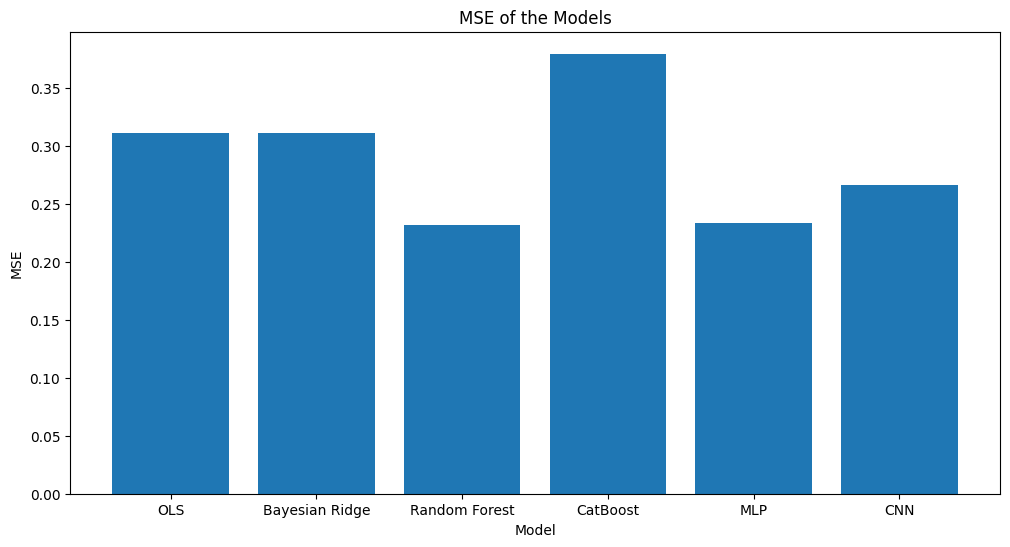

In [301]:
models = []
mse = []

for model_name, residuals in residual_dict.items():
    models.append(model_name)
    mse.append(np.mean(residuals ** 2))

# plot the MSE
plt.bar(models, mse)

# add title
plt.title("MSE of the Models")

# add x and y labels
plt.xlabel("Model")
plt.ylabel("MSE")

# show the plot
plt.show()

# 3 Conclusion

From part 1, we learned that global temperature has been increasing in the past one and half centuries. Specifically, the mean annual temperature in the world increases from around 15 Celsius to 16 Celsius. Interestingly, the temperature increases unevenly across different regions. We see that the countries closer to the North Pole experienced higher temperature increase than countires near the equator. For G20 countries, which represent countries from different continents, their mean, maximum, and minimum annual temperatures have all increased from 1850 to 2015, reinforcing our view regarding global warming. Within the US, we see that all states experienced temperature increase in the last hundred years. Unexpectedly, for unknown reason, we also notice uneven temperature increase--the states closer to the Northeast experienced higher temperature increase than states in the West. From time series analysis, there is a clear and consistent correlation between the month and the temperature and an increasing trend in the Year-on-Year monthly average temperatures. Overall, we can conclude that global warming is a trend that is undeniable and significant.

In Part 2, we modelled local land average temperature using a variety of machine learning methods. We found that Random Forest and neural networks performed the best and believed that their superior handling of the geographical information and their non-linearities were the reasons for their success. Between the two neural networks we considered, we found that MLP performed better than CNN, which suggests that the local temporal information is not as useful, i.e. the inductive bias of the CNN (we are telling the CNN that the input data is a time series and nudges it to look for local temporal patterns) is not helpful. In addtion, we found that CatBoost performed worse than OLS, which is very surprising, as gradient boosting trees are very high performing models. 

For future work, we would like to explore models that have other types of sequential inductive bias, such as recurrent neural networks and transformers. We suspect that they would be more capable to capture the temporal information in the data than CNN.